In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from zoneinfo import ZoneInfo  # Built-in from Python 3.9+


import sys
sys.path.append('../src')  # only needed if you're not packaging yet

from vol_utils import compute_log_returns, annualized_volatility_mean_square

In [2]:
import pandas as pd

df = pd.read_csv("../output/all_vols.csv")
df['date'] = pd.to_datetime(df['date'])  # ensure proper datetime type

In [5]:
def add_har_features(df, vol_col='annualized_vol_30min'):
    df = df.sort_values(['ticker', 'date'])
    df['har_1d'] = df.groupby('ticker')[vol_col].shift(1)
    df['har_1w'] = df.groupby('ticker')[vol_col].shift(1).rolling(window=5, min_periods=5).mean().reset_index(0, drop=True)
    df['har_1m'] = df.groupby('ticker')[vol_col].shift(1).rolling(window=21, min_periods=21).mean().reset_index(0, drop=True)
    return df


from statsmodels.api import OLS, add_constant

def run_cross_sectional_har(df, target_col='annualized_vol_30min'):
    results = []
    
    for date, group in df.groupby('date'):
        # Drop NAs from any HAR column
        sub = group.dropna(subset=['har_1d', 'har_1w', 'har_1m', target_col])
        if len(sub) < 10:  # not enough tickers that day
            continue

        X = sub[['har_1d', 'har_1w', 'har_1m']]
        X = add_constant(X)
        y = sub[target_col]

        model = OLS(y, X).fit()
        r2 = model.rsquared
        errors = model.resid
        
        result = {
            'date': date,
            'beta_0': model.params['const'],
            'beta_1d': model.params['har_1d'],
            'beta_1w': model.params['har_1w'],
            'beta_1m': model.params['har_1m'],
            'r2': model.rsquared,
            'rmse': np.sqrt(np.mean(errors**2)),
            'n_obs': len(sub)
        }
        results.append(result)
    
    return pd.DataFrame(results)

<Axes: title={'center': 'HAR Cross-Sectional Coefficients'}, xlabel='date'>

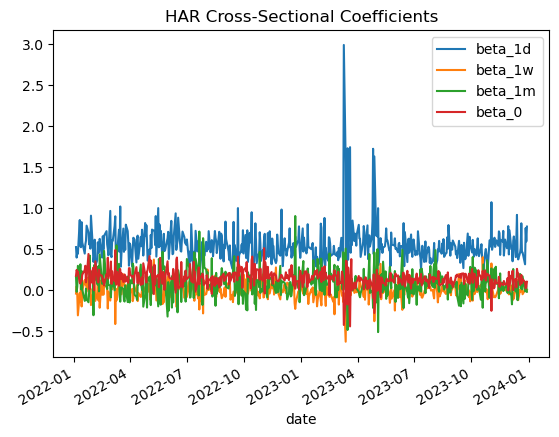

In [ ]:
vol_df = add_har_features(df, vol_col='annualized_vol_30min')
cs_har_results = run_cross_sectional_har(vol_df)

cs_har_results.plot(x='date', y=['beta_1d', 'beta_1w', 'beta_1m','beta_0'], title="HAR Cross-Sectional Coefficients")


In [11]:
def reindex_to_global_calendar(df, date_col='date', ticker_col='ticker', vol_col='annualized_vol_30min'):
    global_dates = pd.date_range(df[date_col].min(), df[date_col].max(), freq='B')  # assuming business days
    all_tickers = df[ticker_col].unique()
    
    full_idx = pd.MultiIndex.from_product([all_tickers, global_dates], names=[ticker_col, date_col])
    
    df_reindexed = df.set_index([ticker_col, date_col]).reindex(full_idx)
    return df_reindexed.reset_index()

df2= reindex_to_global_calendar(vol_df, date_col='date', ticker_col='ticker', vol_col='annualized_vol_30min')
df2.pivot

<bound method DataFrame.pivot of        ticker       date      open    close  annualized_vol_1min  \
0           A 2022-01-03  158.5900  156.420             0.587181   
1           A 2022-01-04  155.1900  151.200             0.598884   
2           A 2022-01-05  150.7800  148.680             0.551088   
3           A 2022-01-06  147.2600  149.110             0.621580   
4           A 2022-01-07  148.3050  145.142             0.472356   
...       ...        ...       ...      ...                  ...   
261555    ZTS 2023-12-25       NaN      NaN                  NaN   
261556    ZTS 2023-12-26  194.9950  195.520             0.280355   
261557    ZTS 2023-12-27  194.7377  196.970             0.332238   
261558    ZTS 2023-12-28  197.4100  197.270             0.345685   
261559    ZTS 2023-12-29  196.2500  197.410             0.335967   

        annualized_vol_5min  annualized_vol_15min  annualized_vol_30min  \
0                  0.481546              0.392435              0.269868   


<Axes: title={'center': 'HAR Cross-Sectional RMSE and R2'}, xlabel='date'>

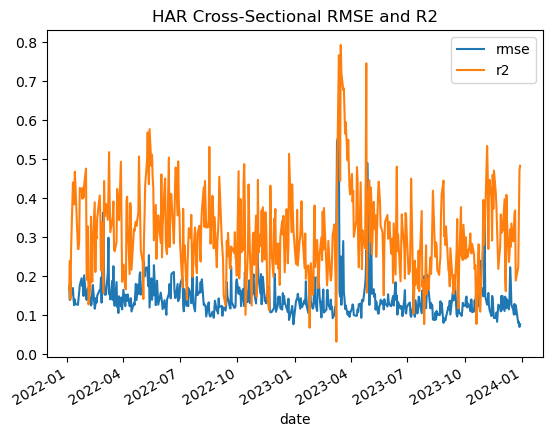

In [8]:
cs_har_results.plot(x='date', y=['rmse', 'r2'], title="HAR Cross-Sectional RMSE and R2")

In [17]:
# Load your all_vols.csv
df = pd.read_csv("../output/all_vols.csv")
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['ticker', 'date'])


# Create HAR lag features
df['har_1d'] = df.groupby('ticker')['annualized_vol_5min'].shift(1)
df['har_1w'] = df.groupby('ticker')['annualized_vol_5min'].shift(1).rolling(5).mean().reset_index(0, drop=True)
df['har_1m'] = df.groupby('ticker')['annualized_vol_5min'].shift(1).rolling(21).mean().reset_index(0, drop=True)



# Create next-day target
df['target'] = df.groupby('ticker')['annualized_vol_5min'].shift(-1)


# List of all valid dates
dates = sorted(df['date'].dropna().unique())

# Container for forecasts
results = []

# Start loop from 20th date
# Start loop from 20th date
for i in range(20, len(dates)-1):
    lookback_dates = dates[i-20:i]
    today = dates[i]

    # Combine all data from the lookback window
    train = df[df['date'].isin(lookback_dates)]
    train = train.dropna(subset=['har_1d', 'har_1w', 'har_1m', 'target'])

    # Fit model for each day in the lookback
    daily_betas = []

    for d in lookback_dates:
        sub = train[train['date'] == d]
        if len(sub) < 10:
            continue
        X = add_constant(sub[['har_1d', 'har_1w', 'har_1m']])
        y = sub['target']
        model = OLS(y, X).fit()
        daily_betas.append(model.params)

    # If no usable days, skip
    if len(daily_betas) == 0:
        continue

    # Average coefficients
    avg_beta = pd.DataFrame(daily_betas).mean()

    # Predict for today
    pred_df = df[df['date'] == today].dropna(subset=['har_1d', 'har_1w', 'har_1m'])
    if pred_df.empty:
        continue

    X_pred = add_constant(pred_df[['har_1d', 'har_1w', 'har_1m']])
    pred = X_pred @ avg_beta

    out = pred_df[['ticker', 'date']].copy()
    out['forecast'] = pred.values
    out['actual'] = df.loc[X_pred.index, 'target'].values
    out['resid'] = out['actual'] - out['forecast']

    results.append(out)

# Combine all daily forecasts
forecast_df = pd.concat(results, ignore_index=True)


In [21]:
results

[       ticker       date  forecast    actual     resid
 115299      A 2023-02-01  0.431113  0.487365  0.056253
 115219    AAL 2023-02-01  0.479207  0.587331  0.108124
 115407    AAP 2023-02-01  0.471854  0.432074 -0.039780
 115148   AAPL 2023-02-01  0.444785  0.458344  0.013559
 115265   ABBV 2023-02-01  0.383144  0.320588 -0.062556
 ...       ...        ...       ...       ...       ...
 115542   XRAY 2023-02-01  0.433450  0.545951  0.112501
 115211    YUM 2023-02-01  0.360073  0.307024 -0.053050
 115253    ZBH 2023-02-01  0.359580  0.517382  0.157802
 115507   ZBRA 2023-02-01  0.480134  0.783871  0.303737
 115341    ZTS 2023-02-01  0.397905  0.446181  0.048276
 
 [461 rows x 5 columns],
       ticker       date  forecast    actual     resid
 26416    AAL 2023-02-02  0.651584  0.599031 -0.052553
 26884    AAP 2023-02-02  0.582841  0.539232 -0.043609
 26410   AAPL 2023-02-02  0.563658  0.822180  0.258523
 26445   ABBV 2023-02-02  0.438928  0.344073 -0.094855
 26724    ABC 2023-02-02  